In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
from bayes_opt import BayesianOptimization
from scipy.optimize import root_scalar
import pymongo
import seaborn as sns
from scipy import special
import White_class
from scipy import integrate

In [10]:
connection = pymongo.MongoClient('localhost',27017)

db = connection.db
db_slowing = db.Slowing_beta

max_parameters = db_slowing.distinct(key = 'params',filter = {'target' : {'$gte' : 23}})

    
# db_expected = db.Expected_model

# max_parameters = db_expected.distinct(key='params',filter = {'target' : {"$gte" : 0.06665}})

for i in max_parameters:
    print(i)

{'beta_1': 0.6911214540860955, 'beta_2': 1.9838373711533497, 'det_1': 123.8816734003357, 'det_2': 15.47986286008237, 'laseroff': 505566.16489952744, 'laseron': 171312.19591657026, 'main_det': 18.781174363909454}
{'beta_1': 0.8771854931017979, 'beta_2': 0.3455165723311565, 'det_1': 86.0771982533266, 'det_2': 24.878089230895103, 'laseroff': 419330.15785740287, 'laseron': 164860.90948892327, 'main_det': 18.368808121665094}
{'beta_1': 0.8771854931017979, 'beta_2': 2.073099433986939, 'det_1': 86.0771982533266, 'det_2': 24.878089230895103, 'laseroff': 419330.15785740287, 'laseron': 164860.90948892327, 'main_det': 18.368808121665094}
{'beta_1': 1.1367351723014811, 'beta_2': 3.079894787432582, 'det_1': 144.78111610404227, 'det_2': 23.80748589572974, 'laseroff': 497112.83930515894, 'laseron': 148650.18152238324, 'main_det': 19.521177206048268}


In [11]:
test = White_class.Whitelight(**max_parameters[3])

In [13]:
test.motion_trace()

Completed in 7.39 s.                                                
Completed in 7.50 s.                                                
Completed in 8.02 s.                                                
Completed in 8.63 s.                                                
Completed in 8.49 s.                                                
Completed in 8.54 s.                                                
Completed in 8.59 s.                                                
Completed in 8.92 s.                                                
Completed in 8.63 s.                                                
Completed in 9.01 s.                                                
Completed in 9.07 s.                                                
Completed in 8.58 s.                                                
Completed in 8.54 s.                                                
Completed in 8.74 s.                                                
Completed in 8.76 s.              

In [14]:
test.percentage()

0.028565989384724762

In [12]:
#Define the constants
Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
mag_field_grad = 1252.8168984164048*x0
waist = 0.012/x0
v_max = 20
z_max = 384.855e-3/x0
z_start = 384.855e-3/x0
dz = 0.0005/x0
dv = 0.05
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(0,3500000,1)

# The detunings used in the PRAs:
P = np.array([0.010, 0.050, 0.1, 0.2])
intensities = 2.*P/(np.pi*(0.012)**2)/Isat
power_index = 2

#Make the axis:
zz = np.linspace(-1*z_max,z_max+dz,100)
vv = np.linspace(-1*v_max,v_max+dv,100)
Z,V = np.meshgrid(zz,vv)



H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(B=0,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=-1.5/Gamma, q=0, p=0,gJ=-0.00002,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [13]:
def Fixed_detune_MgF_MOT(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff,s,d1,d2,d3,d4,pol1,pol2,pol3,pol4):
    det_side = det_1/Gamma
    det_side2 = det_2/Gamma
    Avg_X = np.average(E_X)
    init_pow = 0.5*2./(np.pi*(0.012)**2)/Isat
    
    def Gaussain_Beam_Diagonal(R:np.array,waist):
        return np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)
    
    def Bessel_Intensity(n_order,beta):
        return special.jv(n_order,beta)**2
    
    def Heav_step(t):
        if laseron<=t and t<laseron+14:
            return -1*(t-laseron-7)*((t-laseron-7)**2-49*3)*1/686*1/2+1/2
        elif laseron+14<=t and t<laseroff:
            return 1
        elif t>=laseroff and t<laseroff+14:
            return (t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2 + 1/2
        else:
            return 0    
        
    laserBeams = pylcp.laserBeams()
    
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(2,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(2,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(1,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(1,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(0,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(0,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(-1,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(-1,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(-2,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(-2,beta_2)}])

# Main Slowing Laser
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(2,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(2,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(1,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(1,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(0,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(0,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(-1,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(-1,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(-2,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(-2,beta_2)}])
# Plus Sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(2,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(2,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(1,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(1,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(0,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(0,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(-1,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(-1,beta_2)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(-2,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
                                     's': lambda R,t : init_pow*Gaussain_Beam_Diagonal(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(-2,beta_2)}])
    
    def MOT_step(t):
        if laseroff<=t and t<laseroff+14:
            return -1*(t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2+1/2
        elif laseroff+14<=t:
            return 1
        else:
            return 0     
        

    for ii, Eg_i in enumerate(E_X):
        if ii==0:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
        elif ii==1:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}]) 
        elif ii==2:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
        else:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])

    return laserBeams

In [14]:
def Coil_field(I,R:np.array):
    n = 510
    s = 0.1016 # in meter
    rad = 0.071976 # in meter
    def dBx(theta,L):
        dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
        rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
        dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
        # print(dl,rprime,dB)
        return dB[0]
    def dBy(theta,L):
        dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
        rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
        dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
        return dB[1]
    
    def dBz(theta,L):
        dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
        rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
        dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
        return dB[2]
    
    
    Bx = integrate.quad(dBx,0,2*np.pi,args=(-s))[0]-integrate.quad(dBx,0,2*np.pi,args=(s))[0]
    By = integrate.quad(dBy,0,2*np.pi,args=(-s))[0]-integrate.quad(dBy,0,2*np.pi,args=(s))[0]
    Bz = integrate.quad(dBz,0,2*np.pi,args=(-s))[0]-integrate.quad(dBz,0,2*np.pi,args=(s))[0]
    
    return np.array([Bx,By,Bz])*n*10000 # Return in Gauss
    


In [29]:
def slow_bayesian(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff):
    laserBeams = Fixed_detune_MgF_MOT(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff,intensities,-2.5,0.22,-0.668,-0.4729,-1,-1,1,1)
    magField = lambda R,t : Coil_field(3.5,R)
    rateeq = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    
    v_longitudinal = np.linspace(14,21,8)
    v_trans = np.linspace(0,0.5,5)
    sols = list()
    counter = 0
    
    def trap_condition(t,y):
        if abs(y[-6])*1000*x0<10 and abs(y[-4])*1000*x0<10 and abs(y[-3])<5e-2 and abs(y[-1])<5e-2:
            val = -1.
        else:
            val = 1.
        return val
    
    def lost_condition(t,y):
        if y[-6]*1000*x0>30 or abs(y[-4])*1000*x0>10:
            val = -1.
        else:
            val=1.
        return val
    
    trap_condition.terminal = True
    lost_condition.terminal = True
    
    for v0_l in v_longitudinal:
        for v0_t in v_trans:
            rateeq.set_initial_position_and_velocity(np.array([-1*z_start/np.sqrt(2),-1*z_start/np.sqrt(2),0]),np.array([v0_l/np.sqrt(2),v0_l/np.sqrt(2),v0_t]))
            rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

            rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [trap_condition, lost_condition],max_step=1e5,progress_bar = 1,method='LSODA')
            sols.append(rateeq.sol)
            # if abs(sol.r[0][-1])*1000*x0<10 and abs(sol.r[2][-1])*1000*x0<10 and abs(sol.v[0][-1])<5e-2 and abs(sol.v[2][-1])<5e-2:
            #     counter+=1
            #     # print(rateeq.sol.v[0], rateeq.sol.v[2])
            # else:
            #     continue
    return sols, counter

In [30]:
sols_rate, counter = slow_bayesian(**max_parameters[0])

C:\Users\qmopl\anaconda3\envs\LCP\lib\site-packages\pylcp\fields.py:1220: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([beam.intensity(R, t) for beam in self.beam_vector])


Completed in 4:13.                                                  
Completed in 4:57.                                                      
Completed in 5:00.                                                      
Completed in 5:17.                                                      
Completed in 4:32.                                                       
Completed in 4:04.                                                 
Completed in 5:30.                                                      
Completed in 5:26.                                                      
Completed in 14:20.                                                     
Completed in 4:54.                                                       
Completed in 4:49.                                                  
Completed in 5:38.                                                      
Completed in 5:19.                                                      
Completed in 5:20.                                            

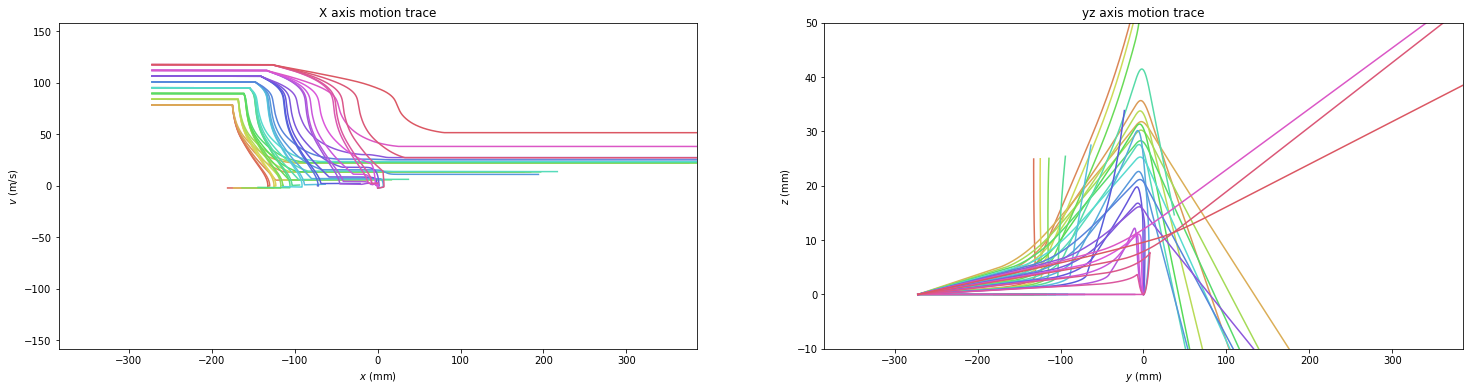

In [31]:
fig, ax = plt.subplots(1, 2,figsize=(25,6))
# plt.imshow(rateeq.profile['F'].F[0]/mass*1e-3*a0, origin='lower',
#            extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
#                    (np.amin(vv*v0)), (np.amax(vv*v0))),
#            aspect='auto',cmap='gray')
# cb1 = plt.colorbar()
# cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax[0].set_xlabel('$x\ (\mathrm{mm})$')
ax[0].set_ylabel('$v\ (\mathrm{m/s})$')
ax[0].set_title('X axis motion trace')
ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[0].set_ylim(-1*v_max*v0,v_max*v0)
ax[1].set_xlabel('$y\ (\mathrm{mm})$')
ax[1].set_ylabel('$z\ (\mathrm{mm})$')
ax[1].set_title('yz axis motion trace')
ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[1].set_ylim(-10,0.05*1000)
fig.subplots_adjust(left=0.12,right=0.9)

colors = sns.color_palette('hls',len(sols_rate))

for sol,col in zip(sols_rate,colors):
    ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0, color=col)
    ax[1].plot(sol.r[1]*x0*1000,sol.r[2]*x0*1000, color=col)
    
# fig.savefig('./Pictures/numerical_main_det=19.2.png')
# fig.savefig('./Pictures/Expected_main_det=19.8.png')

# fig.savefig("./Pictures/Cross_validation.png")
fig.savefig("./Pictures/Fixed Bfield.png")

In [32]:
for sol in sols_rate:
    if len(sol.t_events[0])==1:
        print(sol.v[0][0]*np.sqrt(2), sol.v[2][0])

18.0 0.25
19.0 0.25
19.0 0.375
20.0 0.125
20.0 0.25
20.0 0.375
21.000000000000004 0.0
21.0 0.125
21.0 0.25
